In [93]:

import datetime
from time import sleep
from binance.client import Client
import pandas as pd
import datetime
import time
import numpy as np
import os
import sys
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.stattools import coint

#from crontab import CronTab
from safe_schedule import SafeScheduler
#add your api keys here
api_key = 'XuozVlFg2WYVemwmHMqCK9j5jSYIV1z3MoDAXY76X2JiCbbgcw7dGxvE0eGVsqhH'
secret_key = 'WyWBCdczLCFvV8fKy16R5dOwhhjK31T7ZrW0cplIzjrvmlSPh5E1KEeAEh5c9I6s'

#Open location of recorded buy/sell walls
bw_location = '/home/me/Documents/BWA/data/watcher/buywalls/'
sw_location = '/home/me/Documents/BWA/data/watcher/sellwalls/'
save_port = '/githome/me/Documents/BWA/data/bw_portfolios'

#Open binance client
client = Client(api_key, secret_key)

#get current time and format to compare with data
current_milli_time = lambda: int(round(time.time() * 1000))


def get_data(sym,prev_k,k,candle_k='5m'):
    """
    Function downloads hist data from binance API with given timestamps
    """
    #previous kline interval
    prev_k = str(prev_k)
    #current kline interval
    k = str(k)
    #download historical data
    data = client.get_historical_klines(sym,interval= candle_k,start_str =int(prev_k),end_str = int(k))
    data = pd.DataFrame(data,columns=['Open time','Open','High','Low','Close','Volume','Close time','Quote volume','Num trades', 'btc buys', 'coin buys', 'ignore'])
    
    # convert from millesecond time to datetime for potential resampling and readability
    data['Open time'] = data['Open time']/1000
    data['Open time'] = data['Open time'].astype('datetime64[s]')
    data = data.set_index('Open time')
    data = data[['Open','High','Low','Close','Close time','Volume']].astype(float)
    return data

def normalize(data,column="Close",deci = False):
    """
    Function for simple time series normalization 
    """
    if(deci==True):
        norm_close =  data[column].divide(data[column].iloc[0])-1
    else:
        norm_close =  data[column].divide(data[column].iloc[0])
    return norm_close


def to_dt(v,is_milli=True):
    """
    Function to convert timestamp to datetime object
    has parameter for millisecond uts timestamp
    """
    if(is_milli):
        v = datetime.datetime.fromtimestamp(int(v)/1000)
    else:
        v = datetime.datetime.fromtimestamp(int(v))
    return v

def get_freq_sig(loc):
    """
    Function loads all signal csv files and concatenates them into a signle dataframe
    """
    # cd cmd
    os.chdir(bw_location)
    #sorting by file creation (could use normal sort as filenames are timestamps)
    files = filter(os.path.isfile,os.listdir(bw_location))
    files =  [int(f) for f in files]
    files = list(files)
    #Create frequency signal dataframe
    fs_df = pd.DataFrame(files)
    #sort again
    fs_df = fs_df[0].sort_values()
    #starttime,endtime
    st,end = to_dt(fs_df.iloc[0]),to_dt(fs_df.iloc[-1])
    bw_freq = []
    
    f_len = int(len(os.listdir(loc)))
    for c,i in enumerate(os.listdir(loc)):
        try:
            curr = pd.read_csv(loc+i)
        except Exception as e:
            print(i,e)
 
        curr.columns = ['Coin','Close','Profit','Loss','Date']  
        bw_freq.append(curr)
        if((c/f_len)%10==0):
            pct = str(int((c/f_len)*100))
            print("{}% of files loaded".format(pct))
    bw_freq = pd.concat(bw_freq)
    bw_freq = bw_freq[['Date','Coin','Close']]
    bw_freq.columns = ['Date','Coin','Close']
    bw_freq = bw_freq.sort_values(['Date'],ascending=False)
    #print(all_w.head(), len(all_w))
    #bw_freq['all_freq'] = bw_freq.groupby('Coin')['Coin'].transform('count')
    #bw_freq = bw_freq.sort_values(['Date'],ascending=False)    
    print(st,end)
    print(to_dt(now), now)
    print(fs_df.head())
    return bw_freq

def clean_fs(fs):
    """
    Function to clean frequency signal dataframe
    """
    fs =fs.drop_duplicates()
    fs = fs.sort_values(['Date'],axis=0)
    fs['Date_m'] = fs['Date']
    fs['Date'] = fs['Date']/1000
    fs['Date'] = fs['Date'].astype('datetime64[s]')

    rolling_f = {}
    f_col = []
    """
    for i in fs.iterrows():
        coin = i[1][1]
        if(coin in rolling_f.keys()):
            rolling_f[coin] += 1
            f_col.append(rolling_f[coin])
        else:
            rolling_f[coin] = 1
            f_col.append(rolling_f[coin])
    print(len(fs),len(f_col))
    fs['rolling_freq'] = f_col
    """    
    return fs

def unix_time_millis(dt):
    """
    Function to convert unix time to millesecond
    """
    epoch = datetime.datetime.utcfromtimestamp(0)
    return (dt - epoch).total_seconds() * 1000.0



def interval(intv,st,end):
    """
    Function to resample frequency dataframe to specified frequency
    
    """
    intv_list = []
    out = pd.DataFrame()
    prev = st
    while(prev<end):
        curr = prev+int(86400000*intv)
        n = to_dt(curr).strftime('%Y-%m-%d')
        p = to_dt(prev).strftime('%Y-%m-%d')
        
        print(p,"  |  ",n)
        
        prev = curr
        p = datetime.datetime.strptime(p, '%Y-%m-%d')
        n = datetime.datetime.strptime(n, '%Y-%m-%d')
        intv_list.append(p)
        data = fs_c.loc[p:n]
        #print(data.sort_values('rolling_freq',ascending=False))
        out = pd.concat([out,data],axis=0)
        
    return out.sort_index(),intv_list
    #files.sort(key=lambda x: os.path.getmtime(x))
#loop through datetime index
def get_last_n(n):
    trades = pd.DataFrame()
    idex = []

    print(all_c.iloc[-n:].index)
    for i in all_c.iloc[-n:].index:
        print("\n",i,"\n",pt)
        milli_index = unix_time_millis(i)

        #bool value for if buy signal
        sig = all_sig.loc[i]
        vol = all_vol.loc[i]
        hist = all_c.loc[i]

        try:


            daily_vol = vol.sort_values(ascending=False)
            print(daily_vol.head(9))

            port = list(daily_vol.head(9).index)
            d_port = pd.DataFrame({"Price":hist.loc[port].values,"Signal":sig.loc[port].values})

            d_port['Coin'] = port
            d_port['Date'] = i

            print(d_port)

            trades = pd.concat([trades,d_port],axis=0)
            #print(port)
        except:
            pass
        #print(daily_vol.head(8))

    trades.index = trades['Date']
    trades = trades[["Coin","Price","Signal"]]
    return trades

In [228]:
#get freq. signal df
freq_loc = '/home/me/Documents/BWA/data/freq_concat.csv'
fs = pd.read_csv(freq_loc)
#clean freq. signal df
fs_c = clean_fs(fs)
#multilevel indexing for interval tracking
fs_c = fs_c.set_index(['Date','Coin'])
print(fs_c.head(3))
print(fs_c.tail(3))
#Create start and end for interval dataframe 
st,end = fs_c.index[0][0],fs_c.index[-1][0]
st,end = unix_time_millis(st),unix_time_millis(end)

#30d interval for portfolio generation
intv = 30
#make multiindex frequency dataframe 
#works on fs_c
freq_df,intv_list = interval(intv,st,end)
#group by Coin
cgroups = freq_df.groupby('Coin')
#make list of all syms/dates in dataframe.... the index
coins = list(freq_df.index.get_level_values('Coin').drop_duplicates())
dates = list(freq_df.index.get_level_values('Date').drop_duplicates())

print(coins)
#test print of grouped dataframe
coin = cgroups.get_group(coins[0])
print(coin.tail())

                              Unnamed: 0     Close    Profit      Loss  \
Date                Coin                                                 
2018-08-24 04:09:22 ENGBTC             0  0.000099  0.000101  0.000097   
                    DASHBTC            1  0.021344  0.021771  0.020917   
2018-08-24 04:15:06 THETABTC           2  0.000015  0.000016  0.000015   

                                     Date_m  
Date                Coin                     
2018-08-24 04:09:22 ENGBTC    1535083762289  
                    DASHBTC   1535083762289  
2018-08-24 04:15:06 THETABTC  1535084106238  
                            Unnamed: 0     Close    Profit      Loss  \
Date                Coin                                               
2019-01-19 21:12:29 KNCBTC       91977  0.000039  0.000040  0.000038   
                    BRDBTC       91976  0.000058  0.000059  0.000057   
                    POABTC       91978  0.000009  0.000009  0.000009   

                                   Dat

# BW freq signal visualization

-used time delta between singal events for smoothing signal and creating tradable actions

## Daily resampling for signal/event generation

### creates a dataframe for all coins w/ signals for trading/backtesting
Makes a single csv w/ all coins and multilevel indexing by portfolio time
https://alphascientist.com/feature_engineering.html

c_hist is feature df

In [270]:
all_coins = pd.DataFrame()
for sym in coins:
    coin = cgroups.get_group(sym)
    
    #the secret sauce, extracting value from our data
    #for this example im using the time difference between the signal event occurence to determine enter/exits
    t_dif = []
    for i in range(0,len(coin)-1):
        t1 = coin['Date_m'].iloc[i]
        t2 = coin['Date_m'].iloc[i+1]
        td = (t2-t1)
        #if(td) signal logic
        t_dif.append(td)
    t_dif.append(0)
    #print(t_dif==coin['t_diff'])
    coin = coin.assign(t_dif = t_dif)
    coin.t_dif = coin.t_dif.shift(1)
    
    coin = coin.fillna(method='bfill')
    coin.t_dif = coin.t_dif.pct_change()
    coin = coin[['Close','t_dif']].copy()
    coin.Close = normalize(coin)
    coin.fillna(method='bfill')
    
    #make copy w/ no index for resample and hist data sync
    #create daily signals from intraday signal dataset
    dc = coin.reset_index().copy()
    dc.index = dc.Date
    #Daily resample
    daily_coin = dc.resample('D').sum()
    
    #daily resampled date index
    dates = list(daily_coin.index)
    print(sym)
    print(dates[0].strftime('%Y-%m-%d'),"   |   ",dates[-1].strftime('%Y-%m-%d'))
    prev_k,k = int(dates[0].timestamp()*1000), int(dates[-1].timestamp()*1000)
    
    #Download historical data
    c_hist = get_data(sym,prev_k,k,candle_k='1d')
    
    #extract signal for resampled signal dataframe and create signal column (-1,1) ...maybe (-1,0,1)
    c_hist['Close_diff'] = c_hist['Close'].diff().apply(np.sign)
    
    # log of 5 day moving average of volume

    c_hist['5dlv'] = c_hist.Volume.rolling(5).mean().apply(np.log) 

    # daily volume vs. 200 day moving average

    c_hist['v_3v'] = c_hist.Volume/ c_hist.Volume.rolling(3).mean()-1
    c_hist['vpct'] =  c_hist.Volume.pct_change()
    c_hist['3vpct'] = c_hist['vpct'].rolling(3).sum()

    
    c_hist['bw_sig'] = daily_coin.t_dif
    c_hist['sig3'] = c_hist["bw_sig"].apply(np.sign)
    c_hist['sig3'] = c_hist['sig3'].replace(0,-1)
    c_hist = c_hist.fillna(0) 
    c_hist["daily_returns"] = (c_hist['Close']/c_hist['Open'])-1
    """
    #Visualize trading range and signal
    c_hist2 = c_hist[["Close","sig3"]].copy()
    c_hist2.Close = normalize(c_hist2,deci=True)
    c_hist2["High"] = normalize(c_hist,column="High",deci=True)
    c_hist2["Low"] = normalize(c_hist,column="Low",deci=True)
    c_hist2.plot(figsize=(8,5))
    #plt.savefig("/home/me/Pictures/{}range_signal.png".formate(sym))
    
    c_hist[['sig3','Close_diff']].plot(grid=True,figsize=(8,5))
    """


    c_hist['Market Returns'] = np.log(c_hist['Close'] / c_hist['Close'].shift(1))
    c_hist['Strategy Returns'] = c_hist['Market Returns'] * c_hist['sig3'].shift(1)
    c_hist['Coin'] = sym
    c_hist = c_hist.reset_index()
    c_hist = c_hist.set_index(['Open time','Coin'])

    all_coins = pd.concat([all_coins,c_hist])
    
#dts is dates for resampled df
dts = all_coins.index.get_level_values(0)

fol = dts[0].strftime('%Y-%m-%d')+"_"+dts[-1].strftime('%Y-%m-%d')
print(fol)
#save all_coin to csv
fname = '/home/me/Documents/BWA/data/bw_portfolios/{}'.format(fol)
if os.path.exists(fname) == False:
    os.mkdir(fname)
    all_coins.to_csv(fname+"all_coin.csv".format("30"))

all_coins

DASHBTC
2018-08-24    |    2019-01-17
ENGBTC
2018-08-24    |    2019-01-17
THETABTC
2018-08-24    |    2019-01-19
APPCBTC
2018-08-24    |    2019-01-19
GVTBTC
2018-08-24    |    2019-01-19
OAXBTC
2018-08-24    |    2019-01-19
AIONBTC
2018-08-24    |    2019-01-07
HCBTC
2018-08-24    |    2019-01-19
WINGSBTC
2018-08-24    |    2019-01-19
POLYBTC
2018-08-24    |    2019-01-19
ARDRBTC
2018-08-24    |    2019-01-19
ZENBTC
2018-08-24    |    2019-01-19
CMTBTC
2018-08-24    |    2019-01-19
IOTABTC
2018-08-24    |    2019-01-19
NEBLBTC
2018-08-24    |    2019-01-19
ETHBTC
2018-08-24    |    2019-01-18
ICXBTC
2018-08-24    |    2019-01-18
LOOMBTC
2018-08-24    |    2019-01-18
NANOBTC
2018-08-24    |    2019-01-18
REPBTC
2018-08-24    |    2019-01-19
MODBTC
2018-08-24    |    2019-01-19
LSKBTC
2018-08-24    |    2019-01-19
BNBBTC
2018-08-24    |    2019-01-19
VIBEBTC
2018-08-24    |    2019-01-19
ELFBTC
2018-08-24    |    2019-01-19
MANABTC
2018-08-24    |    2019-01-16
WAVESBTC
2018-08-24    |

ReadTimeout: HTTPSConnectionPool(host='api.binance.com', port=443): Read timed out. (read timeout=10)

# Plotting correlation heatmap for all coins.
Used for feature engineering

In [284]:
#cgroups = all_coins.groupby('Coin')
d = dates[-30:]
print(d[-1])
last_month = all_coins.loc[d[0]:d[-1]].copy()
corr = last_month.loc[d[0]:d[-1]].corr()
#print(corr)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdYlGn_r', mask = (corr >= 0.9))

2019-01-19 00:00:00


UnsortedIndexError: 'Key length (1) was greater than MultiIndex lexsort depth (0)'

# Show overall perfomance of signal strategy vs BTC benchmark

In [231]:
#Download BTC hist data for benchmark
bench = get_data("BTCUSDT",int(unix_time_millis(dts[0])),int(unix_time_millis(dts[-1])),"1d")

BW Portfolio Returns:

| Avg buy 'n hold: -0.05904900945116648% 
| BW Strategy: 1.9517357232558112% 
| BTC -0.6112085336344557% 

Performance w/ 10,000 starting value

| Avg buy 'n hold: $3297 
| BW Strategy: $23405
| BTC hold $3887


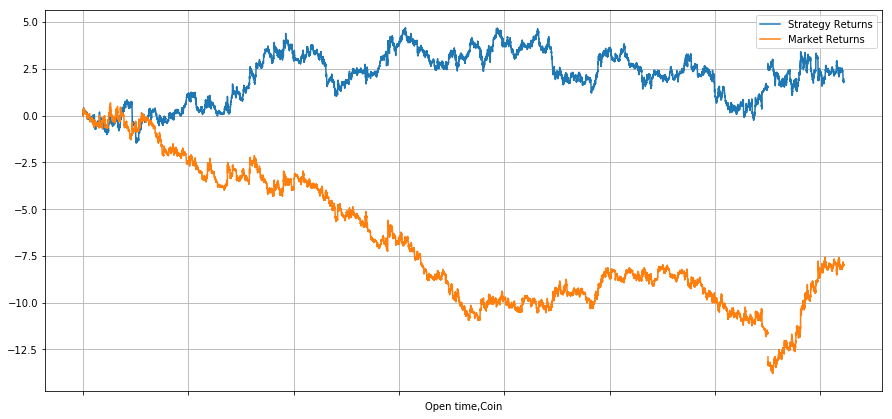

In [232]:
#starting capital
cap = 10000
#make log btc returns
btc = np.log(bench['Close'] / bench['Close'].shift(1))

btc_returns = btc.cumsum().iloc[-1]
s_returns = all_coins['Strategy Returns'].cumsum().iloc[-1]
m_returns = (all_coins['Market Returns'].cumsum().iloc[-1]/len(coins))

#hypothetical returns per strategy
s_value = cap+(cap*s_returns)
m_value = cap+(cap*m_returns)

#hypothetical growth of 10k
btc_value = int(cap+(cap*btc_returns)) 
s_value_usd = int(cap+(cap*(s_returns+btc_returns)))
m_value_usd = int(cap+(cap*(m_returns+btc_returns)))


print("BW Portfolio Returns:\n\n| Avg buy 'n hold: {}% \n| BW Strategy: {}% \n| BTC {}% \n".format(m_returns,s_returns,btc_returns))
print("Performance w/ 10,000 starting value\n\n| Avg buy 'n hold: ${} \n| BW Strategy: ${}\n| BTC hold ${}".format(m_value_usd,s_value_usd,btc_value))
total_returns = all_coins[['Strategy Returns','Market Returns']].cumsum().plot(figsize=(15,7),grid=True)

# Test daily universe selection/weights and trade targets

-Possible features to look for: volatility, inv vol, momentum
-Most simple possibility is to use volume as ranking. Volume is strongly correlationed to strategy returns

In [286]:
last_n_hist = pd.DataFrame()
portfolio = pd.DataFrame()
dates = all_coins.index.get_level_values('Open time').drop_duplicates()
coins = all_coins.index.get_level_values('Coin')
last_dates = dates[-5:]
for day in dates[-5:]:
    curr = all_coins.loc[day].sort_values(['bw_sig','vpct'],ascending=[False,False]).iloc[:10].copy()
    curr = curr[['Open','Close','bw_sig','sig3']].copy()
    curr['Date'] = day
    portfolio = pd.concat([portfolio,curr])
    

    #curr

    #print("\n",day,"\n",pt)
    #print(curr)
    
#all_coins.sort_values(["Open time","v_3v"]).iloc[-10:]
portfolio = portfolio.reset_index()
portfolio.set_index(['Date','Coin'])

Open     Close      bw_sig  sig3
Date       Coin                                          
2019-01-15 ENGBTC    0.000079  0.000079  810.020323   1.0
           THETABTC  0.000013  0.000013  518.467401   1.0
           LOOMBTC   0.000012  0.000012  464.139161   1.0
           KNCBTC    0.000038  0.000037  393.379496   1.0
           LRCBTC    0.000011  0.000011  335.284411   1.0
           ETHBTC    0.035005  0.033502  296.486304   1.0
           POLYBTC   0.000033  0.000033  194.077430   1.0
           PIVXBTC   0.000211  0.000207  189.822035   1.0
           HCBTC     0.000358  0.000337  144.770178   1.0
           AEBTC     0.000101  0.000114  128.303682   1.0
2019-01-16 APPCBTC   0.000012  0.000012  378.150316   1.0
           NANOBTC   0.000236  0.000241  377.398139   1.0
           DASHBTC   0.019342  0.019597  263.649230   1.0
           ETHBTC    0.033514  0.033836  231.468089   1.0
           LRCBTC    0.000011  0.000014  219.102337   1.0
           STRATBTC  0.000282  0.000307  174.803803   1.0
           PIVXBTC   0.000207  0.000211  148.724916   1.0
           OAXBTC    0.000025  0.000028  108.522730   1.0
           ARDRBTC   0.000014  0.000015   84.746213   1.0
           ARNBTC    0.000071  0.000073   82.939154   1.0
2019-01-17 NANOBTC   0.000241  0.000244  287.104054   1.0
           ZENBTC    0.001213  0.001269  203.848933   1.0
           OAXBTC    0.000028  0.000030  188.705987   1.0
           DASHBTC   0.019593  0.019618  145.241489   1.0
           CLOAKBTC  0.000307  0.000319  133.255073   1.0
           HCBTC     0.000339  0.000318  118.219522   1.0
           BNBBTC    0.001697  0.001750  115.265839   1.0
           GVTBTC    0.000987  0.001024  109.701863   1.0
           ENGBTC    0.000082  0.000085  108.374408   1.0
           NEBLBTC   0.000305  0.000313   96.743635   1.0
2019-01-18 WINGSBTC  0.000021  0.000021  502.437339   1.0
           WAVESBTC  0.000712  0.000703  499.127625   1.0
           LOOMBTC   0.000013  0.000012  492.434622   1.0
           MODBTC    0.000085  0.000090  365.477338   1.0
           NASBTC    0.000157  0.000157  325.241321   1.0
           ETHBTC    0.033644  0.033148  280.651935   1.0
           GVTBTC    0.001024  0.001001  264.213239   1.0
           NEBLBTC   0.000313  0.000316  247.193926   1.0
           IOTABTC   0.000084  0.000084  179.737595   1.0
           NANOBTC   0.000244  0.000241  134.002848   1.0
2019-01-19 ELFBTC    0.000030  0.000031  692.083472   1.0
           CMTBTC    0.000007  0.000008  249.695843   1.0
           NEBLBTC   0.000316  0.000321  230.352789   1.0
           WAVESBTC  0.000703  0.000699  174.300209   1.0
           STRATBTC  0.000272  0.000280  173.530298   1.0
           POLYBTC   0.000033  0.000033  171.977162   1.0
           XMRBTC    0.012349  0.012366  170.179420   1.0
           AEBTC     0.000118  0.000119  149.638107   1.0
           OAXBTC    0.000044  0.000041  134.969340   1.0
           GVTBTC    0.001000  0.001016   84.573403   1.0

In [279]:
print(dates[-1])
all_coins.loc[dates[-1]].sort_values(['bw_sig','vpct'],ascending=[False,False]).head(9)

2019-01-19 00:00:00


,Open,High,Low,Close,Close time,Volume,Close_diff,5dlv,v_3v,vpct,3vpct,bw_sig,sig3,daily_returns,Market Returns,Strategy Returns
Coin,,,,,,,,,,,,,,,,
ELFBTC,0.000030,0.000032,0.000030,0.000031,1.547942e+12,1.051929e+07,1.0,15.920837,0.067783,0.508570,0.742721,692.083472,1.0,0.030435,0.030315,-0.030315
CMTBTC,0.000007,0.000008,0.000007,0.000008,1.547942e+12,9.600462e+07,1.0,17.929040,0.262870,1.772190,1.726190,249.695843,1.0,0.066291,0.064186,-0.064186
NEBLBTC,0.000316,0.000329,0.000313,0.000321,1.547942e+12,1.600404e+05,1.0,11.567794,0.339143,0.725575,0.723983,230.352789,1.0,0.018700,0.018528,0.018528
WAVESBTC,0.000703,0.000718,0.000694,0.000699,1.547942e+12,1.591791e+06,-1.0,14.724900,-0.273177,-0.285405,-0.360952,174.300209,1.0,-0.006118,-0.006137,-0.006137
STRATBTC,0.000272,0.000314,0.000271,0.000280,1.547942e+12,2.129056e+06,1.0,14.981057,0.154197,0.516446,-0.464654,173.530298,1.0,0.029801,0.029366,-0.029366
POLYBTC,0.000033,0.000034,0.000033,0.000033,1.547942e+12,3.883817e+06,1.0,15.152042,0.242574,0.778975,-0.027427,171.977162,1.0,0.004236,0.003925,0.003925
XMRBTC,0.012349,0.012492,0.012246,0.012366,1.547942e+12,3.365224e+04,1.0,10.704700,-0.230350,-0.230768,-0.295849,170.179420,1.0,0.001377,0.002105,-0.002105
AEBTC,0.000118,0.000130,0.000116,0.000119,1.547942e+12,2.715644e+06,1.0,15.865537,-0.349011,-0.431342,-1.240758,149.638107,1.0,0.009338,0.008446,0.008446
OAXBTC,0.000044,0.000055,0.000035,0.000041,1.547942e+12,4.063433e+07,-1.0,17.292315,-0.142094,-0.367102,1.868070,134.969340,1.0,-0.063329,-0.066565,-0.066565


In [162]:
import bt
#bt strategy

hold = bt.Strategy('hold', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

hist_stack = []
sig_stack = []
vol_stack = []
pt = "============================"
all_coins = all_coins.sort_values('Open time')
ac_groups = all_coins.groupby('Coin')
#intv_list.append(dts[-1].strftime('%Y-%m-%d'))#to_dt(unix_time_millis(intv_list[-1])+(8640000*30)))
for c,t in enumerate(intv_list):
    #1 interval hist dataframe
    bt_hist_data = pd.DataFrame()
    bt_sig_data = pd.DataFrame()
    bt_vol_data = pd.DataFrame()
    #get start and end dates for interval
    try:
        
        if n == intv_list[-1]:
            curr = all_coins.loc[n:].copy()
            curr = curr.reset_index()
            n = to_dt(now)
            
        else:
            n = intv_list[c+1]
            curr = all_coins.loc[t:n].copy()
            curr = curr.reset_index()
        
    except Exception as e:
        print(e)
        break
    
    print("Portfolio from {} to {} \n{}".format(t,n,pt))
    
    #create copy of df with index selection
    #.drop_duplicates()
    #list of coin
    coins = curr['Coin'].drop_duplicates()
    curr.index = curr["Open time"]
    idex = curr["Open time"]
    cg = curr.groupby('Coin')
    
    i=0
    prev_len = []
    c_bt = []
    for c in coins:
        curr = cg.get_group(c)
        #print(curr)

        if(i==0):
            prev_len.append(len(curr))

        if(len(curr) == prev_len[len(prev_len)-2]):
            #print(bt_hist_data)
            try:
                bt_hist_data[c] = curr.Close.values
                bt_sig_data[c] = curr.sig3.values
                bt_vol_data[c] = curr['v_3v'].values
                
                bt_hist_data.index = curr.index
                bt_sig_data.index = curr.index
                bt_vol_data.index = curr.index
                prev_len.append(len(curr))
            except Exception as e:
                pass

        if(i==5):
            print(bt_hist_data.tail())
        i+=1

            
           
    #Monthly holding backtest
    hist_stack.append(bt_hist_data)
    sig_stack.append(bt_sig_data)
    vol_stack.append(bt_vol_data)
    """
    test = bt.Backtest(hold, bt_hist_data)
    res = bt.run(test)
    res.plot(grid=True)
    res.display()
    plt.show()
    """
    



Portfolio from 2018-08-24 00:00:00 to 2018-09-23 00:00:00 
             DASHBTC    BATBTC    DNTBTC   POWRBTC    RCNBTC  WAVESBTC
Open time                                                             
2018-09-19  0.029939  0.000024  0.000004  0.000024  0.000004  0.000354
2018-09-20  0.030636  0.000025  0.000004  0.000024  0.000004  0.000343
2018-09-21  0.031039  0.000027  0.000004  0.000026  0.000004  0.000334
2018-09-22  0.030444  0.000026  0.000004  0.000027  0.000005  0.000317
2018-09-23  0.030598  0.000026  0.000004  0.000027  0.000004  0.000341
Portfolio from 2018-09-23 00:00:00 to 2018-10-23 00:00:00 
            CLOAKBTC    AGIBTC    RDNBTC   FUELBTC   NEBLBTC   IOTABTC
Open time                                                             
2018-10-19  0.000388  0.000008  0.000086  0.000003  0.000297  0.000076
2018-10-20  0.000404  0.000008  0.000091  0.000003  0.000304  0.000076
2018-10-21  0.000398  0.000008  0.000093  0.000003  0.000315  0.000075
2018-10-22  0.000422  0.000009

In [163]:
#all coin hist data concatenated
all_c = pd.concat(hist_stack,sort=True)
#all coin signals concatenated
all_sig = pd.concat(sig_stack,sort=True)
#all 3d vol vs vol concatenated
all_vol = pd.concat(vol_stack,sort=True)
#add "0" values for no possible position
all_sig = all_sig.fillna(0)
#print(all_c.iloc[0:2])
#print(all_sig.iloc[0:2])
#save/update signal df for live trading
fname = "/home/me/Documents/BWA/data/bw_signal.csv"
all_sig.to_csv(fname)